In [2]:
import os
import librosa
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot  as plt
from os import listdir
from os.path import isfile, join

In [57]:
## File parameter
MODEL_PATH = FOLDER_PATH + '/model/mid2e/'
TRAIN_DATA = FOLDER_PATH+ "/data-emotion/set1/spectograms_313x149_Mel_func/"
LABEL_DATA = FOLDER_PATH + "/data-emotion/set1/mean_ratings_set1.xls"

## DATA PARAMETER
NUM_INSTANCE = 360
TEST_SIZE = 0.2

## Model Parameter
BATCH_SIZE = 8
EPOCHS = 40
MODEL_SAVE = True

## File test

FOLDER_TEST = FOLDER_PATH + '/validate-audio'

In [4]:
FRAME_SIZE = 2048
HOP_LENGTH = int(22050 // 31.25)
DURATION = 15 # In seconds
SAMPLE_RATE = 22050
N_FFT = 2048
N_MELS = 128
MONO = True

In [58]:
def load_data_label(feature_path, label_file_path):
    label_matrix = pd.read_excel(label_file_path, header=0).drop(['Number','TARGET'],axis=1)
    # Load the data from each file and concatenate into a single feature matrix
    feature_matrix = None

    for i in range(1, len(label_matrix) + 1):
        if i < 10:
          i = '00' + str(i)
        elif i < 100:
          i = '0' + str(i)

        file_path = os.path.join(feature_path, str(i) + ".mp3.npy")
        # print("Processed file " + file_path)
        data = np.load(file_path)
        data = [np.expand_dims(data, axis=-1)]
        if feature_matrix is None:
            feature_matrix = data
        else:
            feature_matrix = np.concatenate((feature_matrix, data), axis=0)
    return feature_matrix, label_matrix


In [59]:
 # load feature, label
feature_matrix, label_matrix = load_data_label(TRAIN_DATA, LABEL_DATA)

# feature_matrix = pretrained_model.predict(feature_matrix)

# feature_matrix = pd.DataFrame(feature_matrix)
# # split train, test
# train_features, test_features, train_labels, test_labels = train_test_split(feature_matrix, label_matrix, test_size=TEST_SIZE, random_state=42)

NameError: ignored

In [38]:
input_columns = ['melody', 'articulation', 'rhythm_complexity', 'rhythm_stability', 'dissonance', 'atonality', 'mode']
output_columns = ['valence', 'energy', 'tension', 'anger', 'fear', 'happy', 'sad', 'tender']

In [47]:
feature_matrix = None
def random_10s(signal):
      section_start = np.random.randint(0, signal.shape[0] - 10 * 22050)
      section_end = section_start + 10 * 22050
      section = signal[section_start:section_end]
      return section
def extract_mel(signal):
      signal = random_10s(signal)

      spectrogram = librosa.feature.melspectrogram(y=signal, sr=22050, n_fft=2048, hop_length=HOP_LENGTH, n_mels=149)

      # convert to decibel scale
      spectrogram_db = librosa.amplitude_to_db(spectrogram, ref=np.max)

      # transpose to have time as the first dimension and frequency as the second dimension
      spectrogram_db = np.transpose(spectrogram_db)

      return spectrogram_db

onlyfiles = [f for f in listdir(FOLDER_TEST) if isfile(join(FOLDER_TEST, f))]
print(onlyfiles)
for i in onlyfiles:
  file_path = os.path.join(FOLDER_TEST, str(i))
  y, sr = librosa.load(file_path)
  data = extract_mel(y)
  data = [np.expand_dims(data, axis=-1)]
  if feature_matrix is None:
      feature_matrix = data
  else:
      feature_matrix = np.concatenate((feature_matrix, data), axis=0)

['dissonance_high.mp3', 'dissonance_low.mp3', 'happy_high.mp3']


In [48]:
pretrained_mid_model = keras.models.load_model(FOLDER_PATH+"/model/" + "/mel-model-4000s/trans-model") #mel-model/ trans-model
pretrained_emotion_model = keras.models.load_model(MODEL_PATH+"cnn_M2E_trans") #mel-model/ trans-model

In [60]:
mid_level_matrix = pretrained_mid_model(feature_matrix)
# emotion_matrix = pretrained_emotion_model(mid_level_matrix)

In [61]:
mid_level = pd.DataFrame(mid_level_matrix, columns=[input_columns])
# emotion_value = pd.DataFrame(emotion_matrix, columns=[output_columns])

array([[<Axes: title={'center': "('melody',)"}>,
        <Axes: title={'center': "('articulation',)"}>,
        <Axes: title={'center': "('rhythm_complexity',)"}>],
       [<Axes: title={'center': "('rhythm_stability',)"}>,
        <Axes: title={'center': "('dissonance',)"}>,
        <Axes: title={'center': "('atonality',)"}>],
       [<Axes: title={'center': "('mode',)"}>, <Axes: >, <Axes: >]],
      dtype=object)

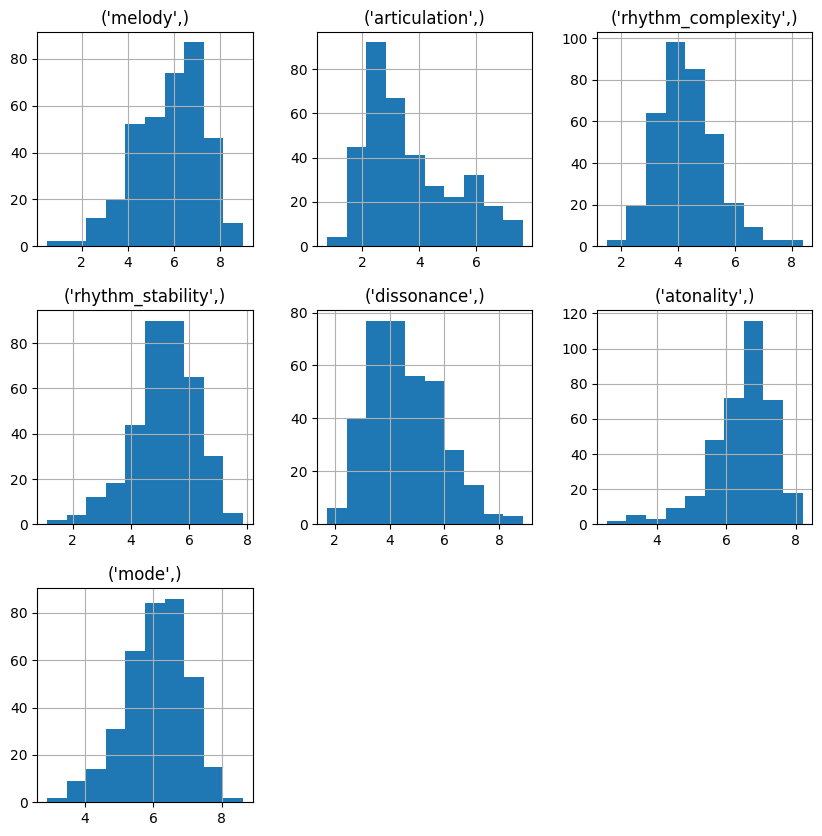

In [67]:
mid_level.hist(figsize=(10,10))

/usr/local/lib/python3.9/dist-packages/numpy/lib/function_base.py:2829: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/usr/local/lib/python3.9/dist-packages/numpy/lib/function_base.py:2830: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


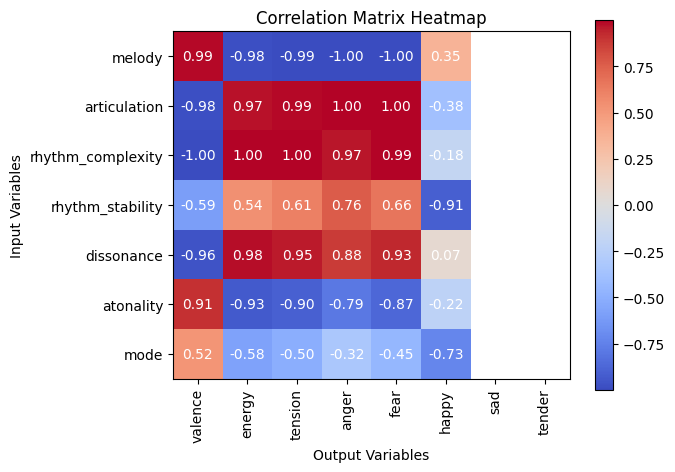

In [56]:
correlation_matrix = np.corrcoef(mid_level, emotion_value, rowvar=False)[:7, 7:]
plt.imshow(correlation_matrix, cmap='coolwarm', interpolation='nearest')
plt.colorbar()
rows, cols = correlation_matrix.shape
for i in range(rows):
    for j in range(cols):
        text = f"{correlation_matrix[i, j]:.2f}"
        plt.text(j, i, text, ha='center', va='center', color='white')
plt.xticks(range(cols), output_columns, rotation='vertical')
plt.yticks(range(rows), input_columns)

plt.title('Correlation Matrix Heatmap')
plt.xlabel('Output Variables')
plt.ylabel('Input Variables')
plt.show()

In [52]:
mid_level['id'] = onlyfiles
emotion_value['id'] = onlyfiles

In [53]:
mid_level

,melody,articulation,rhythm_complexity,rhythm_stability,dissonance,atonality,mode,id
0,4.938634,7.741394,5.796624,7.217404,6.843589,5.894831,5.102352,dissonance_high.mp3
1,4.930646,7.824797,5.579998,7.497358,6.097642,6.316998,6.118119,dissonance_low.mp3
2,5.422260,6.190393,4.583483,7.120867,5.005222,6.682800,5.996252,happy_high.mp3


In [54]:
emotion_value

,valence,energy,tension,anger,fear,happy,sad,tender,id
0,2.136425,7.108444,6.729960,4.932274,5.144271,2.500062,1.0,1.0,dissonance_high.mp3
1,2.317777,6.824176,6.563654,5.089508,5.057161,2.189832,1.0,1.0,dissonance_low.mp3
2,3.372235,5.750194,5.375358,3.460761,3.661546,2.441469,1.0,1.0,happy_high.mp3


In [ ]:
correlation_matrix = np.corrcoef(test_features, y_pred, rowvar=False)[:7, 7:]